# Amy Hatman
# 11.2 Exercise: Survival Analysis
## February 25, 2024

In [1]:
# Function to download the data. 
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

In [2]:
# Needed packages for the assignment
import numpy as np
import pandas as pd

import survival
import nsfg
import thinkstats2
import thinkplot

## Exercise 13-1

### In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent's first marriage, if applicable, encoded in century-months.

### Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival function for the duration of marriage. 

### Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

### Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [3]:
# reading the data
resp2002 = survival.ReadFemResp2002()
resp2010 = survival.ReadFemResp2010()

In [4]:
# this function helps clean the data. 
def CleanData(resp):
    # replaces invalid values in the cmdivorcx column
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    # computes the duration for each scenario and labels them
    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [5]:
# cleaning the data with the function above
CleanData(resp2002)
CleanData(resp2010)

In [6]:
# creating new data with only those married prior to the data collection
married2002 = resp2002[resp2002.evrmarry == 1]
married2010 = resp2010[resp2010.evrmarry == 1]

In [7]:
# this function plots the survival curves for each decade
def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [8]:
# this function uses resampling to plot the curve of divorce for each decade
def ResampleDivorceCurveByDecade(resps):
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Group Undivorced", axis=[0, 28, 0, 1])

In [9]:
# this function uses resampling to plot the curve of divorce
def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.05)

    thinkplot.Show(xlabel="Years", axis=[0, 28, 0, 1])

In [10]:
# this function calculates the survival curve 
# returns hazard and survival variables
def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

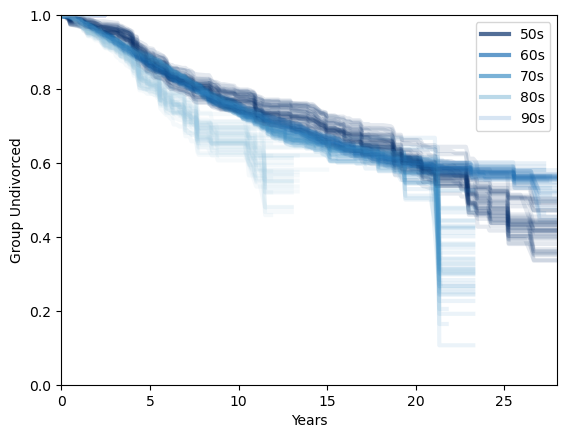

In [11]:
# running all the functions on our data.
ResampleDivorceCurveByDecade([married2002, married2010])

That was an amazing number of functions for one graph!! From this plot we can see how long marriages tend to survive based on the decade it began. It is plain to see that marriages don't last as long as they used to! 

We see that those married in the 50s tend to still be married after 25 years. Those in married in the 60s and 70s tended to stay married for 22-23 years or more. However, those in the 80s and 90s seem to only last 11-14 years in marriage.

One thing to consider however is that this data was compiled in 2002 and 2006-2010 meaning those married in the 90s could possibly only have reached their 11th year overall, or as little as 3 years when the data was gathered.